## plan_pole_transect
Visualize pole locations on Pea Island beach transect.

Profiles were extracted from SfM maps by Jenna on 31 August 2021 - Provisional Data.

#### Read in profiles
Use pandas to read profiles; pull out arrays of  x, y (UTM meters, same for all profiles) and z (m NAVD88).  
Calculate distance along profile from arbitrary starting point.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fnames = ['crossShore_profile_2019_preDorian.xyz', 'crossShore_profile_2019_postDorian.xyz',
          'crossShore_profile_2020_Sep.xyz',       'crossShore_profile_2021_Apr.xyz']
df0 = pd.read_csv(fnames[0],skiprows=1,sep=',',header=None,names=['x','y','z'])
df1 = pd.read_csv(fnames[1],skiprows=1,sep=',',header=None,names=['x','y','z'])
df2 = pd.read_csv(fnames[2],skiprows=1,sep=',',header=None,names=['x','y','z'])
df3 = pd.read_csv(fnames[3],skiprows=1,sep=',',header=None,names=['x','y','z'])
df0.describe()
x = df0['x'].values
y = df0['y'].values
z0 = df0['z'].values
z1 = df1['z'].values
z2 = df2['z'].values
z3 = df3['z'].values
dist = np.sqrt((x - x[0])**2+(y-y[0])**2)

#### Use Stockdon equation to calculate runup for slope on upper beach and offshore waves


In [29]:
def calcR2(H,T,slope,igflag=0):
    """
    %
    % [R2,S,setup, Sinc, SIG, ir] = calcR2(H,T,slope,igflag);
    %
    % Calculated 2% runup (R2), swash (S), setup (setup), incident swash (Sinc)
    % and infragravity swash (SIG) elevations based on parameterizations from runup paper
    % also Iribarren (ir)
    % August 2010 - Included 15% runup (R16) statistic that, for a Guassian distribution, 
    % represents mean+sigma. It is calculated as R16 = setup + swash/4.  
    % In a wave tank, Palmsten et al (2010) found this statistic represented initiation of dune erosion. 
    %
    %
    % H = significant wave height, reverse shoaled to deep water
    % T = deep-water peak wave period
    % slope = radians
    % igflag = 0 (default)use full equation for all data
    %        = 1  use dissipative-specific calculations when dissipative conditions exist (Iribarren < 0.3)
    %        = 2  use dissipative-specific (IG energy) calculation for all data
    %
    % based on:
    %  Stockdon, H. F., R. A. Holman, P. A. Howd, and J. Sallenger A. H. (2006),
    %    Empirical parameterization of setup, swash, and runup,
    %    Coastal Engineering, 53, 573-588.
    % author: hstockdon@usgs.gov
    # Converted to Python by csherwood@usgs.gov
    """
    g = 9.81

    # make slopes positive!
    slope = np.abs(slope)

    # compute wavelength and Iribarren
    L = (g*T**2) / (2.*np.pi)
    sqHL = np.sqrt(H*L)
    ir = slope/np.sqrt(H/L)

    if igflag == 2:                     # use dissipative equations (IG) for ALL data
        R2 = 1.1*(0.039 * sqHL)
        S = 0.046*sqHL
        setup = 0.016*sqHL

    elif igflag == 1 and ir < 0.3:      # if dissipative site use diss equations
        R2 = 1.1*(0.039 * sqHL)
        S = 0.046*sqHL
        setup = 0.016*sqHL

    else:                               # if int/ref site, use full equations
        setup = 0.35*slope*sqHL
        Sinc = 0.75*slope*sqHL
        SIG = 0.06*sqHL
        S = np.sqrt(Sinc**2 + SIG**2)
        R2 = 1.1*(setup + S/2.)
        R16 = 1.1*(setup + S/4.)

    return R2, S, setup, Sinc, SIG, ir, R16

H = 2.
T = 17.
slp = .05

R2, S, setup, Sinc, SIG, ir, R16 = calcR2(H,T,slp,igflag=0)
mllw = -0.6 #NAVD88
high_water = 1.6 + mllw # high water estimates from Duck and Jenettes
maxHW = R2 + high_water
print('R2: {:.2f}, max HW: {:.2f}'.format(R2, maxHW))

R2: 1.75, max HW: 2.75


#### Plot profiles and pole locations
Apply arbitrary vertical offset to profiles to collapse them. The range of these offsets suggests fairly big uncertainty in the elevation data. 
Define a function to plot pole at ground level with 2 m embedded and 3 m above ground.  
Make plot with vertical exaggeration of 2.1 bazillion.


`edist` - Horizontal retreat of hypothetical eroded profile.  
`pole_locations` - Locations of the pole along the transect...fiddle with this.  
`polz` - Function to plot the poles at the specified locations, with 2 m buried below local ground elev. and 3 m proud.

dist, z: 104.0, 0.9   utmx, utmy: 456574.3, 3948281.3
dist, z: 95.0, 1.4   utmx, utmy: 456565.4, 3948279.8
dist, z: 84.0, 2.2   utmx, utmy: 456554.6, 3948278.0
dist, z: 76.0, 3.5   utmx, utmy: 456546.7, 3948276.7
dist, z: 68.0, 4.5   utmx, utmy: 456538.8, 3948275.4
dist, z: 55.0, 4.9   utmx, utmy: 456526.0, 3948273.2
dist, z: 42.0, 2.6   utmx, utmy: 456513.1, 3948271.1


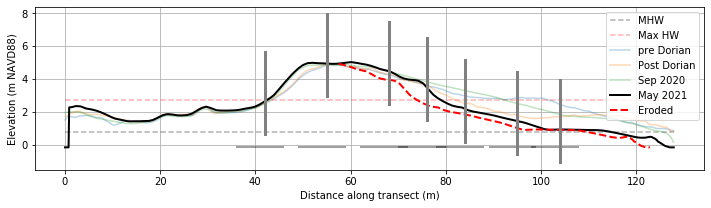

In [30]:
# eyeball offsets to make plot easier to interpret (note this elevates May profile)
ioff1 = -.25
ioff2 = +.3
ioff3 = +.25
mhw = 0.77 # estimated from VDatum
edist = -5 # distance to offset eroded profile
#pole_locations = [96, 89, 82, 75, 68, 55, 42]  # Chris's original
pole_locations = [104, 95, 84, 76, 68, 55, 42]  # Katherine's idea to stretch the array seaward; less overlap
lidar_res_left = 6  # m, depends on orientation
lidar_res_right = 4  # m, depends on orientation

# function to plot pole at ground level, given a distance (pdist) along a  profile (dist and z)
def polz(pdist,dist,z,x,y):
    idx = (dist>=pdist).argmax()
    plt.plot([dist[idx],dist[idx]],[z[idx]-2.,z[idx]+3],'-',c='gray',linewidth=3)
    print('dist, z: {:.1f}, {:.1f}   utmx, utmy: {:.1f}, {:.1f}'.format(dist[idx],z[idx],x[idx],y[idx]))
    plt.hlines(np.min(z), pz-lidar_res_left, pz+lidar_res_right, alpha=0.5)

plt.figure(figsize=(12,3))
plt.plot([dist[0],dist[-1]],[mhw,mhw],'--k',alpha=0.3,label='MHW')
plt.plot([dist[0],dist[-1]],[maxHW,maxHW],'--r',alpha=0.3,label='Max HW')
plt.plot(dist,z0,alpha=0.3,label='pre Dorian')
plt.plot(dist,z1+ioff1,alpha=0.3,label='Post Dorian')
plt.plot(dist,z2+ioff2,alpha=0.3,label='Sep 2020')
plt.plot(dist,z3+ioff3,'-k',linewidth=2,label='May 2021')
plt.plot(dist[500:]+edist,z3[500:]+ioff3,'--r',linewidth=2,label='Eroded')
for pz in pole_locations:
    polz(pz,dist,z3+ioff3,x,y)

plt.grid()
plt.legend()
plt.ylabel('Elevation (m NAVD88)')
_ = plt.xlabel('Distance along transect (m)')


**Comments from Katherine here:** 

How much overlap do we really need? Why is this important? Are there severe edge effects? 

It seems to me that we should either 1) try to cover as much of the profile as we can with the LiDARs since you're interested in runup (i.e., minimal to no overlap) or 2) cluster poles in areas where we expect high gradients in bed-level changes or impacts (i.e., where interpolations in bed-level change between sensors may be a bad assumption: around the "dune toe"(100 m?) and near the dune face). The whole profile looks steeper right now than pre-Dorian, so maybe we'll get more erosion/collision at the dune?

I plotted the horizontal lidar resolution because I was having a hard time visualizing.

(-0.5, 0.5)

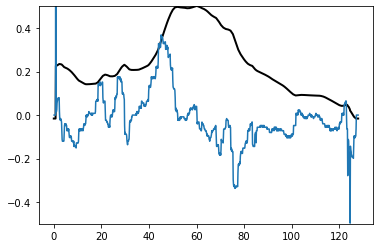

In [8]:
# plot beach slope
slope = np.diff(z3)/np.diff(dist)
plt.plot(dist,0.1*(z3+ioff3),'-k',linewidth=2,label='May 2021')
plt.plot(dist[1:],slope)
plt.ylim((-.5,.5))

16


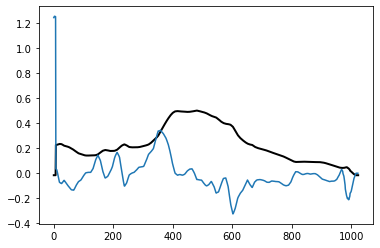

In [14]:
# plot smoothed slope v. index
def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]
N = int(2/.12478)
print(N)
sslope = running_mean(slope,N)
plt.plot(0.1*(z3+ioff3),'-k',linewidth=2,label='May 2021')
plt.plot(sslope)

In [19]:
print(np.median(sslope[690:700]))
print(np.std(sslope[690:700]))

-0.05149328538733515
0.0008375655872101676
